In [22]:
import matplotlib.pyplot as plt
from matplotlib import colors
import mplhep as hep
import scipy
hep.style.use(hep.style.CMS)

import numpy as np
import awkward as ak
import hist as hist2
from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection
from hist.intervals import clopper_pearson_interval

import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch")

def getParticles(genparticles,lowid=22,highid=25,flags=['fromHardProcess', 'isLastCopy']):
    """
    returns the particle objects that satisfy a low id, 
    high id condition and have certain flags
    """
    absid = abs(genparticles.pdgId)
    return genparticles[
        ((absid >= lowid) & (absid <= highid))
        & genparticles.hasFlags(flags)
    ]

def matchH(genparticles,candidatefj):
    higgs = getParticles(genparticles,25)
    is_hWW = ak.all(abs(higgs.children.pdgId)==24,axis=2)

    higgs = higgs[is_hWW]

    matchedH = candidatefj.nearest(higgs, axis=1, threshold=0.8)
    
    return matchedH


class triggerEffProcessor(processor.ProcessorABC):
    def __init__(self, year="2017", jet_arbitration='met'):
        self._year = year
        self._jet_arbitration = jet_arbitration
        
        self._triggers = {
            2016: {
                'e': [
                    "Ele50_CaloIdVT_GsfTrkIdT_PFJet165",
                    "Ele115_CaloIdVT_GsfTrkIdT",
                    "Ele15_IsoVVVL_PFHT600",
                ],
                'mu': [
                    "Mu50",
                    "Mu55",
                    "Mu15_IsoVVVL_PFHT600",
                ],
            },
            2017: {
                'e': [
                    "Ele50_CaloIdVT_GsfTrkIdT_PFJet165",
                    "Ele115_CaloIdVT_GsfTrkIdT",
                    "Ele15_IsoVVVL_PFHT600",
                ],
                'mu': [
                    "Mu50",
                    "Mu15_IsoVVVL_PFHT600",
                ],
            },
            2018: {
                'e': [
                    "Ele50_CaloIdVT_GsfTrkIdT_PFJet165",
                    "Ele115_CaloIdVT_GsfTrkIdT",
                    "Ele15_IsoVVVL_PFHT600",
                ],
                'mu': [
                    "Mu50",
                    "Mu15_IsoVVVL_PFHT600",
                ],
            }
        }
        self._triggers = self._triggers[int(self._year)]
        
        # output
        self.make_output = lambda: {
            'sumw': 0.,
            'signal_kin': hist2.Hist(
                hist2.axis.StrCategory([], name="region", growth=True),
                hist2.axis.Regular(40, 10, 800, name='lep_pt', label=r'lep $p_T$ [GeV]'),
                hist2.axis.Regular(30, 0, 5, name="deltaR_lepjet", label="$\Delta R(l, Jet)$"),
                hist2.storage.Weight(),
            ),
        }
        
    def process(self, events):
        dataset = events.metadata['dataset']
        selection = PackedSelection()
        weights = Weights(len(events), storeIndividual=True)
        weights.add('genweight', events.genWeight)
        
        output = self.make_output()
        output['sumw'] = ak.sum(events.genWeight)
            
        # leptons
        goodmuon = (
            (events.Muon.pt > 25)
            & (abs(events.Muon.eta) < 2.4)
            & events.Muon.mediumId
        )
        nmuons = ak.sum(goodmuon, axis=1)
        lowptmuon = (
            (events.Muon.pt > 10)
            & (abs(events.Muon.eta) < 2.4)
            & events.Muon.looseId
        )
        nlowptmuons = ak.sum(lowptmuon, axis=1)
            
        goodelectron = (
            (events.Electron.pt > 25)
            & (abs(events.Electron.eta) < 2.5)
            & (events.Electron.mvaFall17V2noIso_WP80)
        )
        nelectrons = ak.sum(goodelectron, axis=1)
        lowptelectron = (
            (events.Electron.pt > 10)
            & (abs(events.Electron.eta) < 2.5)
            & (events.Electron.cutBased >= events.Electron.LOOSE)
        )
        nlowptelectrons = ak.sum(lowptelectron, axis=1)
        
        goodtau = (
            (events.Tau.pt > 20)
            & (abs(events.Tau.eta) < 2.3)
            & (events.Tau.idAntiEle >= 8)
            & (events.Tau.idAntiMu >= 1)
        )
        ntaus = ak.sum(goodtau, axis=1)

        # concatenate leptons and select leading one
        goodleptons = ak.concatenate([events.Muon[goodmuon], events.Electron[goodelectron]], axis=1)
        candidatelep = ak.firsts(goodleptons[ak.argsort(goodleptons.pt)])
        candidatelep_p4 = ak.zip(
            {
                "pt": candidatelep.pt,
                "eta": candidatelep.eta,
                "phi": candidatelep.phi,
                "mass": candidatelep.mass,
                "charge": candidatelep.charge,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )
        
        # missing transverse energy
        met = events.MET
        
        # jets
        fatjets = events.FatJet
        candidatefj = fatjets[
            (fatjets.pt > 200)
        ]

        dphi_met_fj = abs(candidatefj.delta_phi(met))
        dr_lep_fj = candidatefj.delta_r(candidatelep_p4)
    
        if self._jet_arbitration == 'pt':
            candidatefj = ak.firsts(candidatefj)
        elif self._jet_arbitration == 'met':
            candidatefj = ak.firsts(candidatefj[ak.argmin(dphi_met_fj,axis=1,keepdims=True)])
        elif self._jet_arbitration == 'lep':
            candidatefj = ak.firsts(candidatefj[ak.argmin(dr_lep_fj,axis=1,keepdims=True)])
        else:
            raise RuntimeError("Unknown candidate jet arbitration")
    
        
        # match HWWlepqq 
        matchedH = matchH(events.GenPart,candidatefj)
        
        # select events with matched higgs
        matchedH_pt = ak.firsts(matchedH.pt)
        selection.add("matchedH", matchedH_pt > 0)
        
        # select events with only electrons or muons
        selection.add('onemuon', (nmuons == 1) & (nlowptmuons <= 1) & (nelectrons == 0) & (nlowptelectrons == 0) & (ntaus == 0))
        selection.add('oneelectron', (nelectrons == 1) & (nlowptelectrons <= 1) & (nmuons == 0) & (nlowptmuons == 0) & (ntaus == 0))
        
        # trigger
        for channel in ["e","mu"]:
            trigger = np.zeros(len(events), dtype='bool')
            for t in self._triggers[channel]:
                if t in events.HLT.fields:
                    trigger = trigger | events.HLT[t]
            selection.add('trigger'+channel, trigger)
            del trigger
            
        # no cuts
        selection.add("all", np.ones(len(events), dtype='bool'))
        
        regions = {
            "hadel_matched": ["oneelectron", "matchedH"] ,
            "hadmu_matched": ["onemuon", "matchedH"],
 
            "hadel_matched_t": ["oneelectron", "matchedH", "triggere"],
            "hadmu_matched_t": ["onemuon", "matchedH","triggermu"],
        }
        
        # function to normalize arrays after a cut or selection
        def normalize(val, cut=None):
            if cut is None:
                ar = ak.to_numpy(ak.fill_none(val, np.nan))
                return ar
            else:
                ar = ak.to_numpy(ak.fill_none(val[cut], np.nan))
                return ar
    
        # lepton kin
        def fill(region):
            selections = regions[region]
            cut = selection.all(*selections)
            
            output['signal_kin'].fill(
                region = region,
                lep_pt = normalize(candidatelep.pt, cut),
                deltaR_lepjet = normalize(candidatefj.delta_r(candidatelep_p4), cut),
                weight = weights.weight()[cut],
            )
            
        for region in regions:
            fill(region)
        
        return {dataset: output}
            
    def postprocess(self, accumulator):
        return accumulator

In [3]:
from dask.distributed import Client

client = Client("tls://daniel-2eocampo-2ehenao-40cern-2ech.dask.coffea.casa:8786")
client

<Client: 'tls://192.168.42.157:8786' processes=2 threads=4, memory=12.72 GiB>

In [24]:
fileset = {
    'HWW': ["root://xcache/" + file for file in np.loadtxt("data/hwwdata.txt", dtype=str)]
}

hwwout = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=triggerEffProcessor(),
    executor=processor.dask_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
        "client": client,
    },
        maxchunks=30,
)
h = hwwout["HWW"]["signal_kin"]

In [25]:
def error(num, den):
    return abs(clopper_pearson_interval(num.values(), den.values()) - num.values()/den.values())

def get_axis(den):
    return [den.axes.value(i)[0] for i in range(len(den.values()))]

/tmp/ipykernel_842/2640079242.py:2: RuntimeWarning: invalid value encountered in true_divide
  return abs(clopper_pearson_interval(num.values(), den.values()) - num.values()/den.values())
/tmp/ipykernel_842/3500627793.py:15: RuntimeWarning: invalid value encountered in true_divide
  num.values()/den.values(),


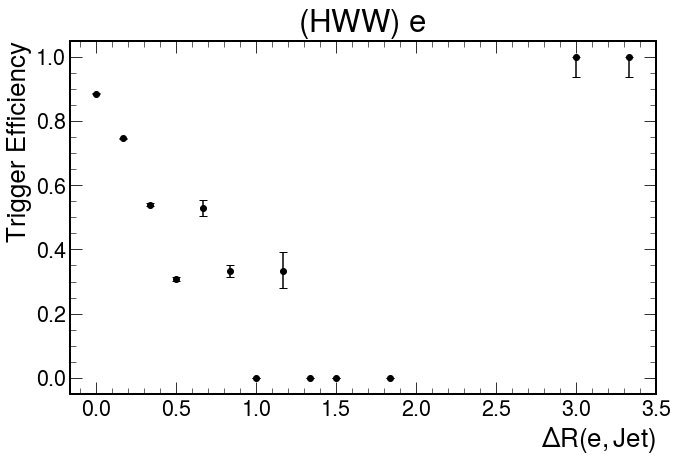

In [29]:
# dR
den = h[{"lep_pt":sum, "region":"hadel_matched"}]
num = h[{"lep_pt":sum, "region":"hadel_matched_t"}]

dr = get_axis(den)
err = error(num, den)

fig, ax = plt.subplots(
    figsize=(10,7),
    tight_layout=True,
)

ax.errorbar(
    dr,
    num.values()/den.values(),
    fmt="ko",
    yerr=err,
    capsize=4,
)
ax.set(
    title="(HWW) $e$",
    xlabel="$\Delta R (e, Jet)$",
    ylabel="Trigger Efficiency"
)
plt.gcf().savefig("hww_etrigger_dr.png")

/tmp/ipykernel_842/2640079242.py:2: RuntimeWarning: invalid value encountered in true_divide
  return abs(clopper_pearson_interval(num.values(), den.values()) - num.values()/den.values())
/tmp/ipykernel_842/3235090381.py:15: RuntimeWarning: invalid value encountered in true_divide
  num.values()/den.values(),


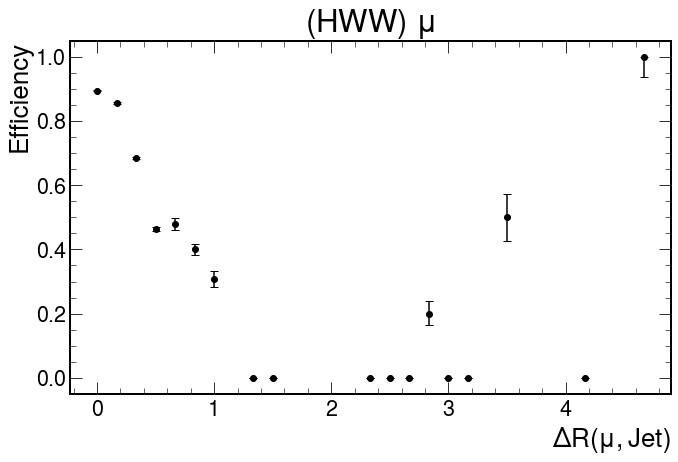

In [30]:
# dR
den = h[{"lep_pt":sum, "region":"hadmu_matched"}]
num = h[{"lep_pt":sum, "region":"hadmu_matched_t"}]

dr = get_axis(den)
err = error(num, den)

fig, ax = plt.subplots(
    figsize=(10,7),
    tight_layout=True,
)

ax.errorbar(
    dr,
    num.values()/den.values(),
    fmt="ko",
    yerr=err,
    capsize=4,
)
ax.set(
    title="(HWW) $\mu$",
    xlabel="$\Delta R (\mu, Jet)$",
    ylabel="Efficiency"
)
plt.gcf().savefig("hww_mutrigger_dr.png")

/tmp/ipykernel_842/2640079242.py:2: RuntimeWarning: invalid value encountered in true_divide
  return abs(clopper_pearson_interval(num.values(), den.values()) - num.values()/den.values())
/tmp/ipykernel_842/690294831.py:15: RuntimeWarning: invalid value encountered in true_divide
  num.values()/den.values(),


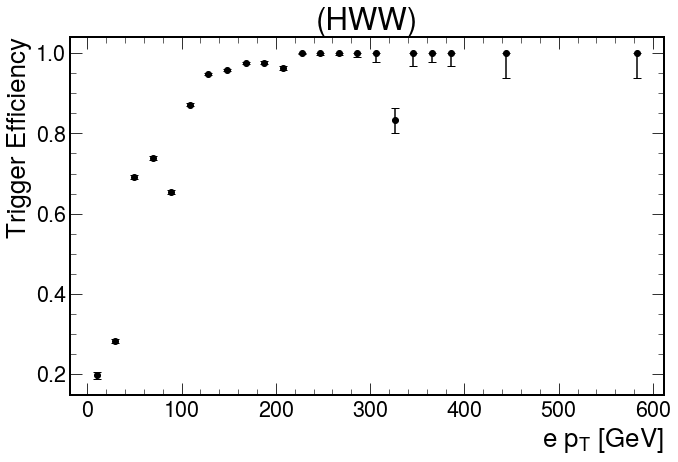

In [31]:
# lep pt
den = h[{"deltaR_lepjet":sum, "region":"hadel_matched"}]
num = h[{"deltaR_lepjet":sum, "region":"hadel_matched_t"}]

leppt = get_axis(den)
err = error(num, den)

fig, ax = plt.subplots(
    figsize=(10,7),
    tight_layout=True,
)

ax.errorbar(
    leppt,
    num.values()/den.values(),
    fmt="ko",
    yerr=err,
    capsize=4,
)
ax.set(
    title="(HWW)",
    xlabel="e $p_T$ [GeV]",
    ylabel="Trigger Efficiency"
)
plt.gcf().savefig("hww_etrigger_pt.png")

/tmp/ipykernel_842/2640079242.py:2: RuntimeWarning: invalid value encountered in true_divide
  return abs(clopper_pearson_interval(num.values(), den.values()) - num.values()/den.values())
/tmp/ipykernel_842/1340506984.py:15: RuntimeWarning: invalid value encountered in true_divide
  num.values()/den.values(),


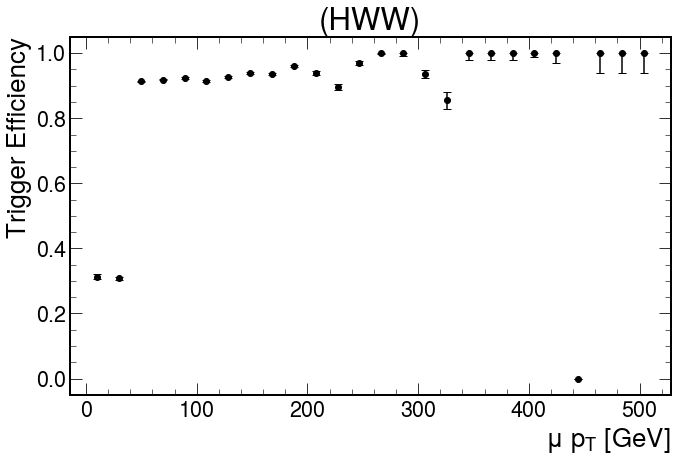

In [32]:
# lep pt
den = h[{"deltaR_lepjet":sum, "region":"hadmu_matched"}]
num = h[{"deltaR_lepjet":sum, "region":"hadmu_matched_t"}]

leppt = get_axis(den)
err = error(num, den)

fig, ax = plt.subplots(
    figsize=(10,7),
    tight_layout=True,
)

ax.errorbar(
    leppt,
    num.values()/den.values(),
    fmt="ko",
    yerr=err,
    capsize=4,
)
ax.set(
    title="(HWW)",
    xlabel="$\mu$ $p_T$ [GeV]",
    ylabel="Trigger Efficiency"
)
plt.gcf().savefig("hww_mutrigger_pt.png")